In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset, DatasetDict
import numpy as np
import torch
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
# 1. Read the CSV file
df = pd.read_csv("data/train.csv")

In [3]:
# 2. Split the data (80% training, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)
print("Training set size:", len(train_df))
print("Test set size:", len(test_df))

Training set size: 6090
Test set size: 1523


In [4]:
train_df.to_csv('train.csv')
test_df.to_csv('test.csv')

In [5]:
# 3. Convert Pandas DataFrames to Hugging Face Datasets
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
datasets = DatasetDict({"train": train_dataset, "test": test_dataset})

In [6]:
# 4. Initialize the tokenizer and define the tokenization function
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
def tokenize_function(examples):
    # Ensure the key "text" matches your CSV column name
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=280)

In [8]:
# 5. Tokenize both the training and test datasets
tokenized_datasets = datasets.map(tokenize_function, batched=True)

Map:   0%|          | 0/6090 [00:00<?, ? examples/s]

Map:   0%|          | 0/1523 [00:00<?, ? examples/s]

In [9]:
# 6. Load the model; assuming a binary classification (num_labels=2)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
print("Using device:", device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cuda:0


In [10]:
# 7. Display the model summary
summary(model)

Layer (type:depth-idx)                                       Param #
BertForSequenceClassification                                --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   23,440,896
│    │    └─Embedding: 3-2                                   393,216
│    │    └─Embedding: 3-3                                   1,536
│    │    └─LayerNorm: 3-4                                   1,536
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  85,054,464
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      590,592
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                               --
├─L

In [11]:
# 8. Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=50,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    logging_dir='./logs',
    logging_steps=10,
    save_strategy="epoch",
    label_names=["labels"] 
)

In [12]:
# 9. Define a compute_metrics function to calculate accuracy
def compute_metrics(logits, labels):
    accuracy = np.mean(logits == labels)
    return {"accuracy": accuracy}

In [13]:
# 10. Create a Trainer instance
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    #compute_metrics=compute_metrics,
)

In [14]:
# 11. Train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss
10,0.616700
20,0.480100
30,0.462300
40,0.429900
50,0.494800
60,0.397600
70,0.452800
80,0.465700
90,0.434900
100,0.393500


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked t

TrainOutput(global_step=9550, training_loss=0.04051280017494052, metrics={'train_runtime': 2225.9921, 'train_samples_per_second': 136.793, 'train_steps_per_second': 4.29, 'total_flos': 4.38141573828e+16, 'train_loss': 0.04051280017494052, 'epoch': 50.0})

In [15]:
# 12. Evaluate on the test set by generating predictions
test_output = trainer.predict(tokenized_datasets["test"])

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [16]:
# Extract the predictions and compute accuracy
predictions = test_output.predictions
predicted_labels = np.argmax(predictions, axis=1)

In [17]:
# Access accuracy from the computed metrics (the key is defined by compute_metrics)
true_labels = np.array(tokenized_datasets["test"]["labels"])
accuracy = compute_metrics(predicted_labels, true_labels)
print("Test Accuracy:", accuracy)

Test Accuracy: {'accuracy': 0.8122127380170716}


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


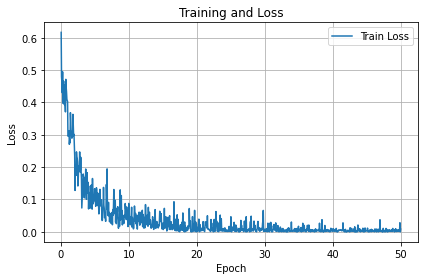

In [22]:
import matplotlib.pyplot as plt

train_loss = []
eval_loss = []
epochs = []

for log in trainer.state.log_history:
    if 'loss' in log.keys() and 'epoch' in log.keys():
        train_loss.append(log['loss'])
        epochs.append(log['epoch'])
    if 'eval_loss' in log.keys() and 'epoch' in log.keys():
        eval_loss.append(log['eval_loss'])

# Plotting
plt.figure()
plt.plot(epochs[:len(train_loss)], train_loss, label='Train Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('training_loss.eps')
plt.show()

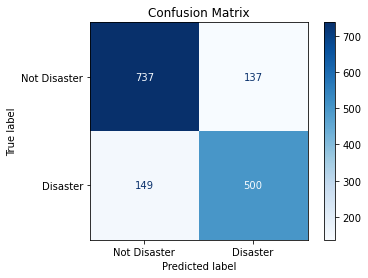

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Disaster", "Disaster"])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.eps')
plt.show()
